In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import mean_absolute_error, mean_squared_error,\
    confusion_matrix, plot_confusion_matrix, classification_report,\
    accuracy_score, plot_roc_curve

from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn import decomposition

from xgboost import XGBRegressor
from xgboost import XGBClassifier

# import data

- baseline

In [3]:
df_baseline = df = pd.read_csv('Output_Data\Model_1_baseline_data.csv')
df.head()

,label,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,...,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,spread_app_id,hispace_app_tags,app_second_class,app_score,u_refreshTimes,u_feedLifeCycle
0,0,3,2,16,147,2,32,6,35,312,...,6,1846,4,46,162,47,14,10.0,0,15
1,1,3,2,16,147,2,32,6,35,312,...,8,1060,4,37,344,20,13,10.0,0,15
2,1,3,2,16,147,2,32,6,35,312,...,8,1060,4,37,344,20,13,10.0,0,15
3,0,3,2,16,147,2,32,6,35,312,...,8,1542,4,47,152,49,17,10.0,0,15
4,0,3,2,16,147,2,32,6,35,312,...,8,1036,4,44,312,43,18,10.0,0,15


In [4]:
df_baseline_sub = df_baseline.sample(n=100000,random_state=23333)
df_baseline_sub.label.value_counts(normalize=True)

# pick one subset, 100k
# that value counts match original most

0    0.98452
1    0.01548
Name: label, dtype: float64

In [5]:
df_baseline_sub.shape

(100000, 24)

- 2nd - enginerred

In [29]:
df = pd.read_csv('Output_Data\data_subset_engineered_for_model.csv')
df.head()

,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,...,pt_d_hour,age_outstanding,device_size_cat,residence_cat,series_dev_outstanding,age_out_dev_big,age_out_dev_norm,great_big_dev,great_nom_dev,ad_click_list_v001_len
0,0,122942,8,2,41,135,5,16,5,20,...,2,2,3,3,2,0,0,0,0,5
1,0,120972,7,2,41,412,2,21,4,12,...,5,2,1,3,2,0,0,0,0,5
2,0,176028,7,2,45,435,2,16,5,19,...,10,2,1,3,2,0,0,0,0,5
3,0,166112,3,2,20,328,5,32,6,29,...,8,1,3,3,2,1,0,0,0,5
4,0,123102,7,2,24,431,5,30,3,35,...,10,2,1,3,2,0,0,0,0,5


In [15]:
df.shape

(100000, 35)

In [16]:
df.columns

Index(['label', 'user_id', 'age', 'gender', 'residence', 'city', 'city_rank',
       'series_dev', 'series_group', 'emui_dev', 'device_name', 'device_size',
       'net_type', 'task_id', 'adv_id', 'creat_type_cd', 'adv_prim_id',
       'inter_type_cd', 'slot_id', 'spread_app_id', 'hispace_app_tags',
       'app_second_class', 'app_score', 'u_refreshTimes', 'u_feedLifeCycle',
       'pt_d_hour', 'age_outstanding', 'device_size_cat', 'residence_cat',
       'series_dev_outstanding', 'age_out_dev_big', 'age_out_dev_norm',
       'great_big_dev', 'great_nom_dev', 'ad_click_list_v001_len'],
      dtype='object')

# BASELINE - TRAIN TEST SPLIT

In [7]:
X = df_baseline_sub.drop(columns='label')
y = df_baseline_sub.label

X_baseline_sub_train, X_baseline_sub_test, y_baseline_sub_train, y_baseline_sub_test = train_test_split(X, y, test_size=0.2, random_state=2333)

X_baseline_sub_train.shape, X_baseline_sub_test.shape

((80000, 23), (20000, 23))

In [8]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_baseline_sub_train_resampled, y_baseline_sub_train_resampled = smote.fit_resample(X_baseline_sub_train, y_baseline_sub_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_baseline_sub_train_resampled).value_counts()) 

Original class distribution: 

0    98452
1     1548
Name: label, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    78764
0    78764
Name: label, dtype: int64


# DESICION TREE BASELINE

In [111]:
# check out the preset params

std_slc = StandardScaler()
dec_tree = DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc), ('dec_tree', dec_tree)])

criterion = ['gini', 'entropy']
max_depth = np.arange(14,15,1)
min_samples_split = np.arange(8,9,1)
min_samples_leaf = np.arange(5,6,1)

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split,
                  dec_tree__min_samples_leaf=min_samples_leaf)

In [112]:
tree_baseline_GS = GridSearchCV(pipe, parameters, scoring='recall')
tree_baseline_GS.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

print('Best Criterion:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best min_samples_split:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best min_samples_leaf:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf'])
print(); 

# 4m12s
# 3*3*3

Best Criterion: gini
Best max_depth: 14
Best min_samples_split: 8
Best min_samples_leaf: 5



In [113]:
tree_baseline_GS.get_params

<bound method BaseEstimator.get_params of GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': array([14]),
                         'dec_tree__min_samples_leaf': array([5]),
                         'dec_tree__min_samples_split': array([8])},
             scoring='recall')>

In [15]:
# 20k data, takes 13.3s
# 100k data, takes 15.2s
# 78764 * 2 data, takes 35.3s
# above for depth 2-12

# 78764 * 2 data, takes 2m 10.9s

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19688
           1       0.04      0.22      0.07       312

    accuracy                           0.91     20000
   macro avg       0.52      0.57      0.51     20000
weighted avg       0.97      0.91      0.94     20000

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     78764
           1       0.09      0.45      0.16      1236

    accuracy                           0.92     80000
   macro avg       0.54      0.69      0.56     80000
weighted avg       0.98      0.92      0.95     80000



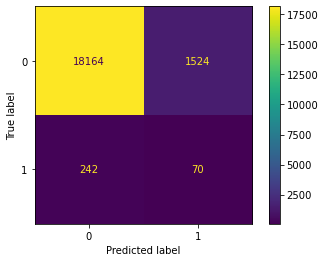

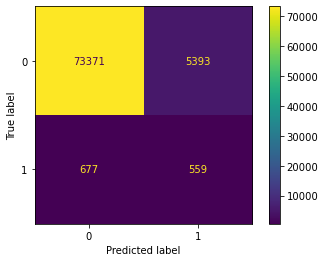

In [114]:
tree_baseline_best_model = tree_baseline_GS.best_estimator_
tree_baseline_best_model.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

plot_confusion_matrix(tree_baseline_best_model,X_baseline_sub_test, y_baseline_sub_test)
print(classification_report(y_baseline_sub_test, tree_baseline_best_model.predict(X_baseline_sub_test)))

plot_confusion_matrix(tree_baseline_best_model,X_baseline_sub_train, y_baseline_sub_train)
print(classification_report(y_baseline_sub_train, tree_baseline_best_model.predict(X_baseline_sub_train)))

Conclusion:
- after hyper tuning, it still works bad for test
- after all, decision tree doesn't work well for imbalanced data, but it's so bad

# BALANCED RANDOM FOREST - BASELINE

In [84]:
BRFC_clf = BalancedRandomForestClassifier(random_state=2333)
BRFC_clf.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled) 

BalancedRandomForestClassifier(random_state=2333)

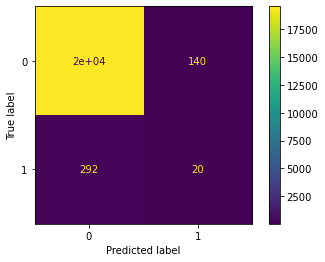

In [86]:
plot_confusion_matrix(BRFC_clf, X_baseline_sub_test, y_baseline_sub_test)

In [85]:
print(classification_report(y_baseline_sub_test, BRFC_clf.predict(X_baseline_sub_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19688
           1       0.12      0.06      0.08       312

    accuracy                           0.98     20000
   macro avg       0.56      0.53      0.54     20000
weighted avg       0.97      0.98      0.97     20000



In [83]:
std_slc = StandardScaler()
brf_clf = BalancedRandomForestClassifier()

brf_pipe = Pipeline(steps=[('std_slc', std_slc), ('brf_clf', brf_clf)])

brf_params = {'model__n_estimators': [100,200] , 'model__min_samples_leaf': [1,3]}

rf_GS = GridSearchCV(estimator = brf_pipe, param_grid = brf_params, cv = 5)
rf_GS.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

rf_GS.best_params_

ValueError: Invalid parameter model for estimator Pipeline(steps=[('std_slc', StandardScaler()),
                ('brf_clf', BalancedRandomForestClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.

# 2ND - TRAIN TEST SPLIT

In [30]:
X = df.drop(columns='label')
y = df.label

X_2_sub_train, X_2_sub_test, y_2_sub_train, y_2_sub_test = train_test_split(X, y, test_size=0.2, random_state=2333)
X_2_sub_train.shape, X_2_sub_test.shape

((80000, 34), (20000, 34))

In [31]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_2_sub_train_resampled, y_2_sub_train_resampled = smote.fit_resample(X_2_sub_train, y_2_sub_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_2_sub_train_resampled).value_counts()) 

Original class distribution: 

0    98452
1     1548
Name: label, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    78764
0    78764
Name: label, dtype: int64


In [32]:
X_2_sub_train_resampled.shape, y_2_sub_train_resampled.shape

((157528, 34), (157528,))

# DESICION TREE 2ND

In [79]:
std_slc = StandardScaler()
dec_tree = DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc), ('dec_tree', dec_tree)])

criterion = ['gini', 'entropy']
max_depth = np.arange(10,11,1)
min_samples_split = np.arange(7,10,1)
min_samples_leaf = np.arange(5,6,1)

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split,
                  dec_tree__min_samples_leaf=min_samples_leaf)


In [80]:
tree_2_GS = GridSearchCV(pipe, parameters,scoring='recall')
tree_2_GS.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

print('Best Criterion:', tree_2_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', tree_2_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best min_samples_split:', tree_2_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best min_samples_leaf:', tree_2_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf'])

print(); 
print(tree_2_GS.best_estimator_.get_params()['dec_tree'])

# 5m57s

Best Criterion: entropy
Best max_depth: 10
Best min_samples_split: 8
Best min_samples_leaf: 5

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=8)


In [81]:
tree_2_GS.get_params

<bound method BaseEstimator.get_params of GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': array([10]),
                         'dec_tree__min_samples_leaf': array([5]),
                         'dec_tree__min_samples_split': array([7, 8, 9])},
             scoring='recall')>

In [82]:
tree_2_best_model = tree_2_GS.best_estimator_
tree_2_best_model.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

Pipeline(steps=[('std_slc', StandardScaler()),
                ('dec_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=5,
                                        min_samples_split=8))])

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19688
           1       0.05      0.24      0.08       312

    accuracy                           0.91     20000
   macro avg       0.52      0.58      0.52     20000
weighted avg       0.97      0.91      0.94     20000



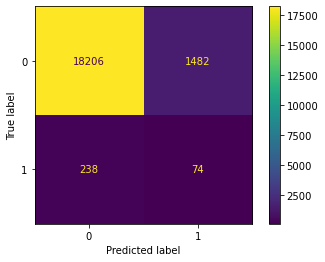

In [85]:
plot_confusion_matrix(tree_2_best_model,X_2_sub_test, y_2_sub_test)
print(classification_report(y_2_sub_test, tree_2_best_model.predict(X_2_sub_test)))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     78764
           1       0.07      0.32      0.11      1236

    accuracy                           0.92     80000
   macro avg       0.53      0.62      0.53     80000
weighted avg       0.97      0.92      0.94     80000



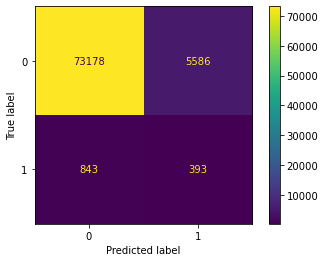

In [86]:
plot_confusion_matrix(tree_2_best_model,X_2_sub_train, y_2_sub_train)
print(classification_report(y_2_sub_train, tree_2_best_model.predict(X_2_sub_train)))

In [115]:
tree_2_GS.best_estimator_

Pipeline(steps=[('std_slc', StandardScaler()),
                ('dec_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=5,
                                        min_samples_split=8))])

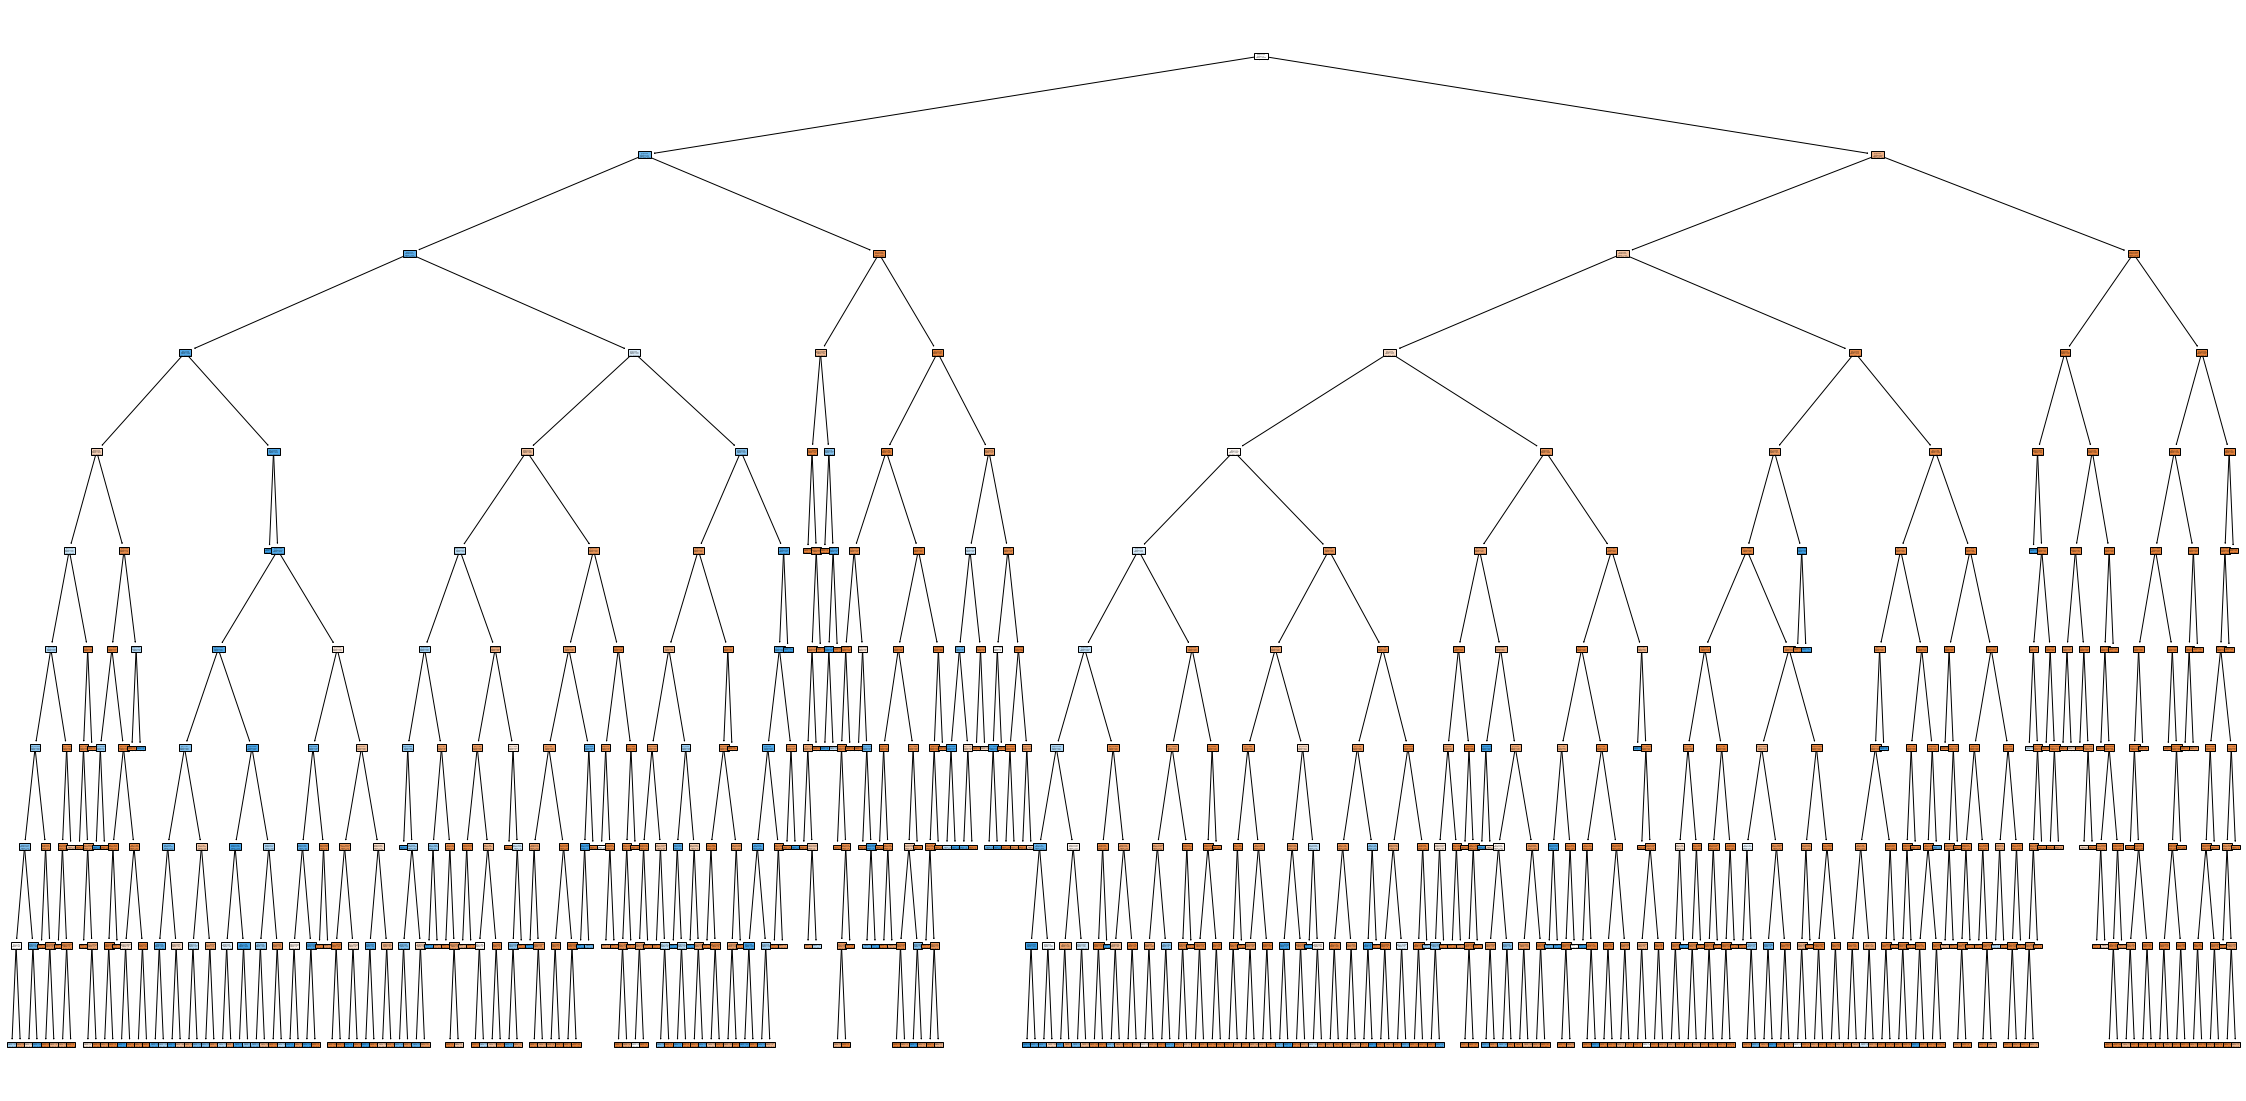

In [116]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10,min_samples_leaf=5,min_samples_split=8)
clf.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

f, ax = plt.subplots(figsize=(40, 20) )
plot_tree(clf,filled=True, ax=ax);

# XGBOOST BASELINE

[13:07:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19688
           1       0.17      0.06      0.09       312

    accuracy                           0.98     20000
   macro avg       0.58      0.53      0.54     20000
weighted avg       0.97      0.98      0.98     20000



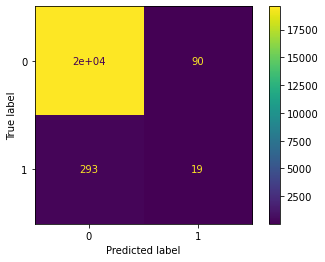

In [153]:
# default
 
xgb_clf_baseline = XGBClassifier()
xgb_clf_baseline.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

print(classification_report(y_baseline_sub_test, xgb_clf_baseline.predict(X_baseline_sub_test)))

plot_confusion_matrix(xgb_clf_baseline, X_baseline_sub_test, y_baseline_sub_test)

[13:25:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     19688
           1       0.05      0.25      0.08       312

    accuracy                           0.91     20000
   macro avg       0.52      0.59      0.52     20000
weighted avg       0.97      0.91      0.94     20000

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     78764
           1       0.06      0.31      0.10      1236

    accuracy                           0.92     80000
   macro avg       0.52      0.62      0.53     80000
weighted avg       0.97      0.92      0.94     80000



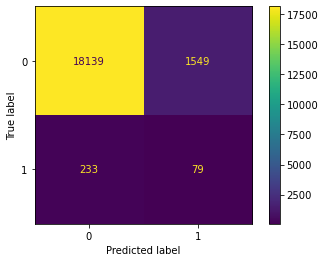

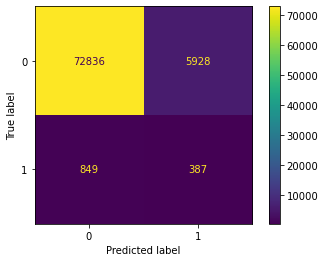

In [189]:
# man tune

xgb_clf_baseline = XGBClassifier(colsample_bytree=0.3, gamma=10,learning_rate=0.1,max_depth=1,scale_pos_weight=.5)
xgb_clf_baseline.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

print(classification_report(y_baseline_sub_test, xgb_clf_baseline.predict(X_baseline_sub_test)))
print(classification_report(y_baseline_sub_train, xgb_clf_baseline.predict(X_baseline_sub_train)))

plot_confusion_matrix(xgb_clf_baseline, X_baseline_sub_test, y_baseline_sub_test)
plot_confusion_matrix(xgb_clf_baseline, X_baseline_sub_train, y_baseline_sub_train)

# XGBOOST 2ND

In [156]:
# default

xgb_clf = XGBClassifier()
xgb_clf.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

c:\Users\qwswe\Anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19688
           1       0.17      0.03      0.05       312

    accuracy                           0.98     20000
   macro avg       0.58      0.51      0.52     20000
weighted avg       0.97      0.98      0.98     20000

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     78764
           1       0.87      0.21      0.33      1236

    accuracy                           0.99     80000
   macro avg       0.93      0.60      0.66     80000
weighted avg       0.99      0.99      0.98     80000



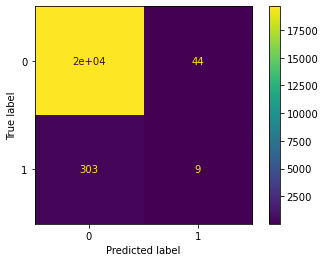

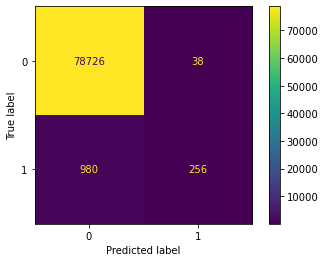

In [158]:
print(classification_report(y_2_sub_test, xgb_clf.predict(X_2_sub_test)))
print(classification_report(y_2_sub_train, xgb_clf.predict(X_2_sub_train)))


plot_confusion_matrix(xgb_clf, X_2_sub_test, y_2_sub_test)
plot_confusion_matrix(xgb_clf, X_2_sub_train, y_2_sub_train)

man test some params

c:\Users\qwswe\Anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     19688
           1       0.04      0.26      0.08       312

    accuracy                           0.90     20000
   macro avg       0.52      0.58      0.51     20000
weighted avg       0.97      0.90      0.93     20000

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     78764
           1       0.06      0.34      0.10      1236

    accuracy                           0.90     80000
   macro avg       0.52      0.63      0.52     80000
weighted avg       0.97      0.90      0.94     80000



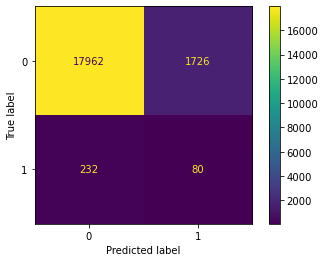

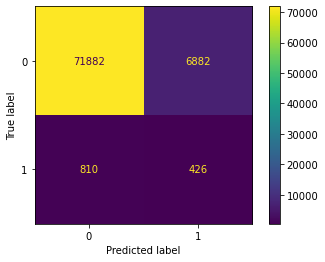

In [118]:
# man test some params

xgb_clf = XGBClassifier(colsample_bytree=.1, gamma=1, learning_rate=.1,
                        max_depth=1, min_child_weight=1, n_estimators=100, n_jobs=16,
                        random_state=0, scale_pos_weight=.8, subsample=1,)
xgb_clf.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

print(classification_report(y_2_sub_test, xgb_clf.predict(X_2_sub_test)))
print(classification_report(y_2_sub_train, xgb_clf.predict(X_2_sub_train)))


plot_confusion_matrix(xgb_clf, X_2_sub_test, y_2_sub_test)
plot_confusion_matrix(xgb_clf, X_2_sub_train, y_2_sub_train)

In [122]:
len(xgb_clf.feature_importances_)

34

In [121]:
len(X_2_sub_train.columns)

34

<AxesSubplot:>

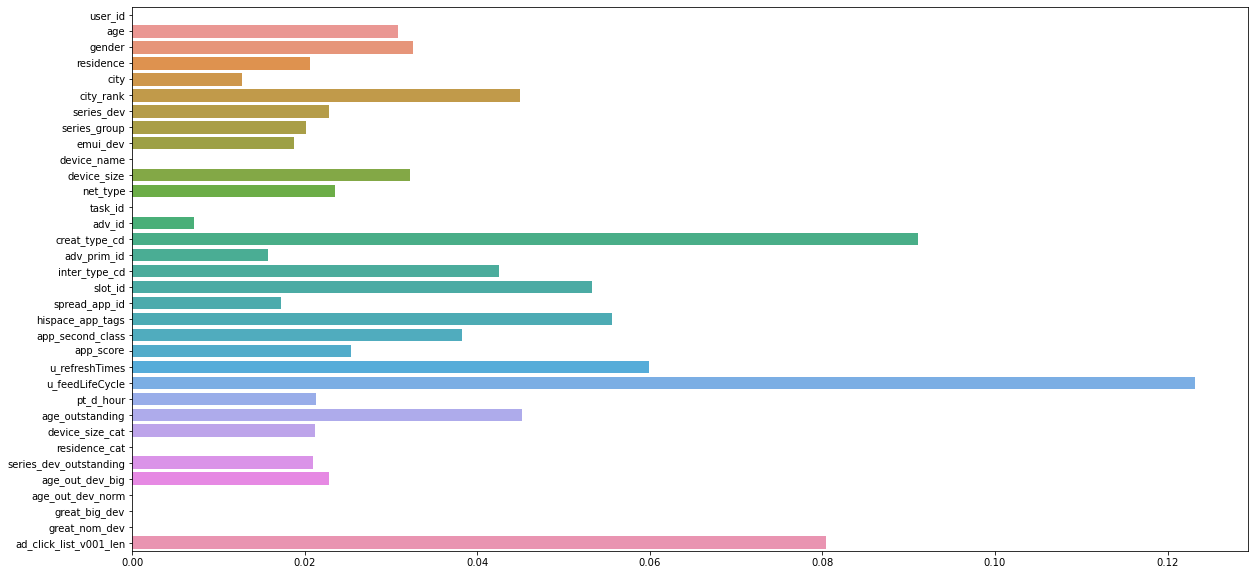

In [131]:
plt.figure(figsize=(20, 10))
sns.barplot(y=X_2_sub_train.columns, x=xgb_clf.feature_importances_)

- pipeline

In [146]:
params = {'max_depth': [1,2,3], 'scale_pos_weight':[2,4,6],
          'colsample_bytree':[.1,.3,.5]}

xg_2_cv = GridSearchCV(estimator = XGBClassifier(), scoring='recall',
                  param_grid = params, cv = 5)
                  
xg_2_cv.fit(X_2_sub_train_resampled, y_2_sub_train_resampled);

# 'gamma': [5,10,15], 'n_estimators': [50,100,150] ,


c:\Users\qwswe\Anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:46] WARNING:

In [147]:
xg_2_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=6, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [148]:
best_mod = xg_2_cv.best_estimator_
best_mod.fit(X_2_sub_train_resampled, y_2_sub_train_resampled);
y_pred = best_mod.predict(X_2_sub_test)

[13:02:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [149]:
y_hat_test = best_mod.predict(X_2_sub_test)

print(classification_report(y_2_sub_test, y_hat_test))


              precision    recall  f1-score   support

           0       0.99      0.73      0.84     19688
           1       0.03      0.53      0.06       312

    accuracy                           0.73     20000
   macro avg       0.51      0.63      0.45     20000
weighted avg       0.97      0.73      0.83     20000



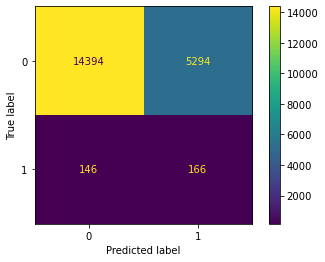

In [150]:
plot_confusion_matrix(best_mod, X_2_sub_test, y_2_sub_test)

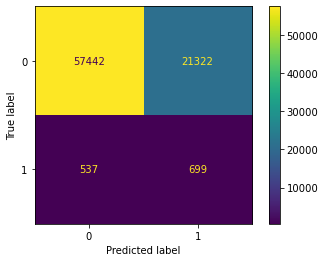

In [151]:
plot_confusion_matrix(best_mod, X_2_sub_train, y_2_sub_train)

In [117]:
type(best_mod)

NameError: name 'best_mod' is not defined